In [1]:
import sys
sys.path.append('../')
import src.utils as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
reload(utils)
from math import factorial
import scipy.stats as stat

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
np.random.seed(2)

## Example 6.1

In [5]:
nsims = 10_000_000
U = np.random.rand(nsims,1) # Uniform values in (0,1)
X = 4*U + 1 # Uniform values in (1,5)
exact = (5**4 - 1**4)/4 # exact value of the integral
simulation = (5-1)* np.sum(X**3) /nsims # approximation 

In [6]:
print('The exact calculation is: ', np.round(exact, 5), ' and using simulations gives: ', np.round(simulation,5))

The exact calculation is:  156.0  and using simulations gives:  156.02194


## Example 6.2
#### Let $X\sim$ exp$(\lambda)$
Then $F_X(x) = 1 - e^{-\lambda x}$
which implies that 
$F_X^{-1}(y) = -\frac{\log(1-y)}{\lambda}$ for $y\in(0,1)$

We will use $\lambda = 2.5$ 

In [7]:
def F_inv_exp(x, l = 2.5):
    return -np.log(1.-x) / l

In [8]:
nsims = 10_000_000
l = 2.5
U = np.random.rand(nsims,1)
X = F_inv_exp(U, l)

We know that an exact calculation yields that 
$$\mathbb{E}[X^n] = \frac{n!}{\lambda^n}$$

### We now compute $\mathbb{E}[X^2]$ 

In [9]:
simulation = np.sum(X**2)/nsims
exact = factorial(2)/ (l**2)

In [10]:
print('The exact calculation is: ', np.round(exact, 5), ' and using simulations gives: ', np.round(simulation,5))

The exact calculation is:  0.32  and using simulations gives:  0.31988


### Let's change the parameters
Now $\lambda = 0.5$ and $n=4$

In [11]:
nsims = 10_000_000
l = 0.5
n = 4
U = np.random.rand(nsims,1)
X = F_inv_exp(U, l)
simulation = np.sum(X**n)/nsims
exact = factorial(n)/ (l**n)

In [12]:
print('The exact calculation is: ', np.round(exact, 5), ' and using simulations gives: ', np.round(simulation,5))

The exact calculation is:  384.0  and using simulations gives:  385.34918


# Pricing options

In [13]:
def simulate_S_T_under_Q(t,T,S,r,sigma,nsims):
    Z = np.random.randn(nsims,1)
    exponent = (r-0.5*sigma**2)*(T-t) + sigma*np.sqrt(T-t)*Z
    return S*np.exp(exponent)

In [14]:
t = 0
T = 1
S = 100
r = 0.03
sigma = 0.1
K = 100
nsims = 10_000_000

S_T = simulate_S_T_under_Q(t,T,S,r,sigma,nsims)

In [15]:
def computeBlackScholesCallPrice(t,T,S,r,sigma,K):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T-t))/(sigma * np.sqrt(T-t))
    d2 = d1 - sigma* np.sqrt(T-t)
    return S*stat.norm.cdf(d1) - K*np.exp(-r*(T-t))*stat.norm.cdf(d2)

In [16]:
def call_option_payoff(K, S):
    return np.maximum(S-K,0)

In [17]:
exact = computeBlackScholesCallPrice(t,T,S,r,sigma,K)
simulation = np.exp(-r*(T-t))*np.sum(call_option_payoff(K, S_T))/nsims

In [18]:
print('The exact calculation is: ', np.round(exact, 4), ' and using simulations gives: ', np.round(simulation,4))

The exact calculation is:  5.5819  and using simulations gives:  5.5803


# Pricing a down-and-out call option

### Parameters are $S_0 = 100$, $r=0.03$, $\sigma = 0.1$, $K = 100$, $B = 90$, and $T=1$.

In [19]:
t = 0
T = 1
S = 100
r = 0.03
sigma = 0.1
K = 100
B = 90
nsims = 1_000_000

In [20]:
GBM = utils.GeometricBrownianMotion(x0 = S, mu = r, sigma = sigma, T = T, Nt = 100)
paths = GBM.simulate(nsims = nsims)

In [21]:
payoff = call_option_payoff(K, paths[-1,:]) * (np.min(paths,axis = 0) > B)
approximation = np.exp(-r*(T-t))*np.sum(payoff)/nsims 

In [22]:
print('Approximation is equal to: ', approximation)

Approximation is equal to:  5.5364589961742805


# Plot for payoff

### Parameters are $S_0 = 100$,  $r=0.03$, $\sigma = 0.1$, $K = 110$, $B = 90$, and $T=1$.

In [23]:
nsims = 20
t = 0
T = 1
S = 100
r = 0.03
sigma = 0.1
K = 110
B = 90

GBM = utils.GeometricBrownianMotion(x0 = S, mu = r, sigma = sigma, T = T, Nt = 100)
paths = GBM.simulate(nsims = nsims)
time = GBM.timesteps

In [24]:
mask =  (np.min(paths,axis = 0) > B)
mask_pays = mask *  (paths[-1,:] > K)
mask_doesntpay = mask *  (paths[-1,:] <= K)
mask_deactivated =  (np.min(paths,axis = 0) <= B)

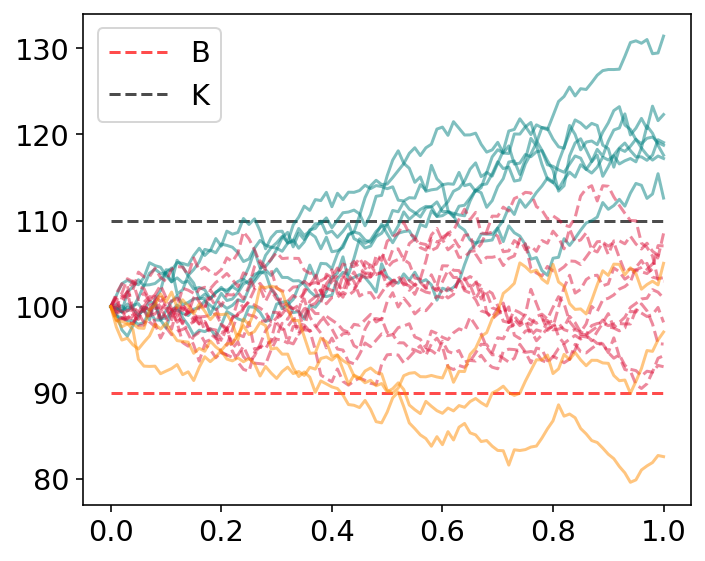

In [25]:
plt.figure(figsize=(5, 4))
plt.hlines(y = B, xmin = time[0], xmax = time[-1], color = 'r', linestyles='--', alpha = 0.7)
plt.hlines(y = K, xmin = time[0], xmax = time[-1], color = 'k', linestyles='--', alpha = 0.7)
plt.legend(['B','K'])
plt.plot(time, paths[:,mask_pays], color="teal", alpha=0.5, linestyle = '-')
plt.plot(time, paths[:,mask_doesntpay], color="crimson", alpha=0.5, linestyle = '--')
plt.plot(time, paths[:,mask_deactivated], color="darkorange", alpha=0.5, linestyle = '-')
resolution_value = 50
plt.tight_layout()
plt.savefig('../figures/payoff_barrier_illustrated.pdf', format="pdf", dpi=resolution_value)
plt.show()